In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
import scipy.stats as stats
from sklearn.pipeline import Pipeline

In [16]:
sns.set_style("white")
sns.set_context("poster")

In [4]:
with open('most_recent_df_log.pickle','rb') as read_file:
   hikes_data = pickle.load(read_file)

df = pd.DataFrame(hikes_data)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 2494
Data columns (total 21 columns):
rating                   978 non-null float64
Established campsites    978 non-null float64
Mountain views           978 non-null float64
Ridges/passes            978 non-null float64
Summits                  978 non-null float64
Waterfalls               978 non-null float64
Wildflowers/Meadows      978 non-null float64
distance_mi              978 non-null float64
highest_pt               978 non-null float64
lat                      978 non-null float64
long                     978 non-null float64
Issaquah Alps            978 non-null uint8
Mount Rainier Area       978 non-null uint8
North Cascades           978 non-null uint8
Snoqualmie Region        978 non-null uint8
National Park Pass       978 non-null uint8
Northwest Forest Pass    978 non-null uint8
Sno-Parks Permit         978 non-null uint8
num_features             978 non-null float64
log_num_reports          978 non-n

# Split out test data

In [6]:
X = df.drop(columns=['rating'],axis=1)
y = df['rating']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

## Run very basic regression 

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_val)

print('MAE:', metrics.mean_absolute_error(y_val, predictions))
print('MSE:', metrics.mean_squared_error(y_val, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, predictions)))
print('R^2:', metrics.explained_variance_score(y_val,predictions))

MAE: 0.587856040522933
MSE: 0.5401355276259057
RMSE: 0.7349391319190356
R^2: 0.08376200936291944


# Cross-Validation  (k-folds)

### Basic Model

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state = 100)

# set up model
cv_lr = LinearRegression()

all_predicts = np.empty(909,)
for i in range(5):
    cv_predictions = cross_val_predict(cv_lr, X, y,cv=kf)
    np.concatenate((all_predicts, cv_predictions), axis=0)

#X and y here are what was used to split into train and validate above. 
print(cross_val_score(cv_lr, X, y, cv=kf, scoring='r2'))
print(np.mean(cross_val_score(cv_lr, X, y, cv=kf, scoring='r2')))

[ 0.02651847  0.0826181   0.07559048 -0.05514643  0.03403232]
0.03272258726441302


**This is about the same as without using cross-validation which is to be expected**

In [9]:
cv_residuals = y-cv_predictions
cv_results_df = pd.DataFrame({'predictions':cv_predictions,'residuals':cv_residuals})
cv_results_df.head()
#cv_results_df.info()

,predictions,residuals
2022,3.156394,1.043606
757,3.133185,-0.633185
2363,2.900351,0.499649
1439,3.244072,-0.944072
1353,3.138966,-0.138966


In [10]:
cv_features_df = pd.DataFrame(X)
cv_features_df['rating'] = y
cv_features_df.head()
#cv_features_df.info()

,Established campsites,Mountain views,Ridges/passes,Summits,Waterfalls,Wildflowers/Meadows,distance_mi,highest_pt,lat,long,...,Mount Rainier Area,North Cascades,Snoqualmie Region,National Park Pass,Northwest Forest Pass,Sno-Parks Permit,num_features,log_num_reports,log_rating_count,rating
2022,1.0,0.0,0.0,0.0,0.0,1.0,9.8,6450.0,47.9458,-123.4255,...,0,0,0,0,0,0,5.0,4.174387,2.944439,4.2
757,1.0,0.0,1.0,0.0,0.0,0.0,6.6,2900.0,46.6642,-121.6003,...,0,0,0,0,0,0,3.0,2.079442,1.791759,2.5
2363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.4670,-123.8455,...,0,0,0,0,0,0,0.0,1.609438,1.609438,3.4
1439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.4356,-121.6560,...,0,0,1,0,0,0,0.0,3.555348,1.098612,2.3
1353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8592,-121.4648,...,0,0,0,0,0,0,0.0,2.564949,0.693147,3.0


In [11]:
cv_feat_res_df = cv_features_df
cv_feat_res_df['cv_residuals'] = cv_residuals
cv_feat_res_df['cv_predictions'] = cv_predictions
cv_feat_res_df.head()

,Established campsites,Mountain views,Ridges/passes,Summits,Waterfalls,Wildflowers/Meadows,distance_mi,highest_pt,lat,long,...,Snoqualmie Region,National Park Pass,Northwest Forest Pass,Sno-Parks Permit,num_features,log_num_reports,log_rating_count,rating,cv_residuals,cv_predictions
2022,1.0,0.0,0.0,0.0,0.0,1.0,9.8,6450.0,47.9458,-123.4255,...,0,0,0,0,5.0,4.174387,2.944439,4.2,1.043606,3.156394
757,1.0,0.0,1.0,0.0,0.0,0.0,6.6,2900.0,46.6642,-121.6003,...,0,0,0,0,3.0,2.079442,1.791759,2.5,-0.633185,3.133185
2363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.4670,-123.8455,...,0,0,0,0,0.0,1.609438,1.609438,3.4,0.499649,2.900351
1439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.4356,-121.6560,...,1,0,0,0,0.0,3.555348,1.098612,2.3,-0.944072,3.244072
1353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.8592,-121.4648,...,0,0,0,0,0.0,2.564949,0.693147,3.0,-0.138966,3.138966


In [12]:
cv_feat_res_df.cv_predictions.describe()

count    782.000000
mean       3.191551
std        0.244361
min        1.955638
25%        3.033047
50%        3.189145
75%        3.352928
max        3.905366
Name: cv_predictions, dtype: float64

Residual plot


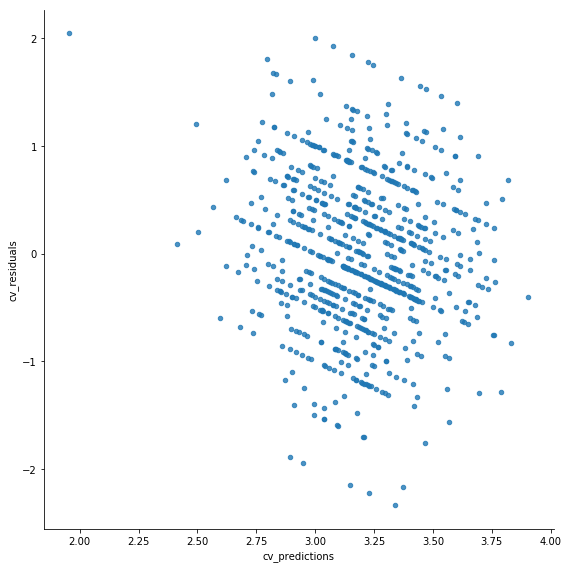

In [13]:
print("Residual plot")
sns.lmplot(y='cv_residuals',x='cv_predictions',data=cv_feat_res_df,scatter_kws={"marker":"D","s": 20},fit_reg=False,height=8)
plt.savefig('log_predictions vs residuals.png',dpi=300,transparent=True)
#v_feat_res_df.plot(x='cv_predictions',y='cv_residuals',kind='scatter',scatter_kws={"marker":"D","s": 10})

# Plot features vs residuals

In [14]:
cv_feat_res_df.columns

Index(['Established campsites', 'Mountain views', 'Ridges/passes', 'Summits',
       'Waterfalls', 'Wildflowers/Meadows', 'distance_mi', 'highest_pt', 'lat',
       'long', 'Issaquah Alps', 'Mount Rainier Area', 'North Cascades',
       'Snoqualmie Region', 'National Park Pass', 'Northwest Forest Pass',
       'Sno-Parks Permit', 'num_features', 'log_num_reports',
       'log_rating_count', 'rating', 'cv_residuals', 'cv_predictions'],
      dtype='object')

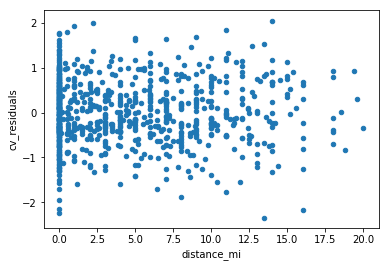

In [15]:
# distance
cv_feat_res_df.plot(x='distance_mi',y='cv_residuals',kind='scatter')

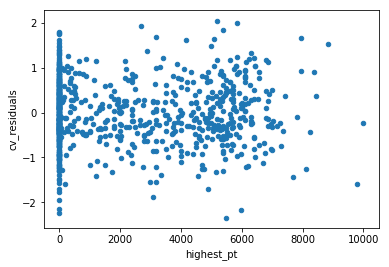

In [16]:
# highest_pt
cv_feat_res_df.plot(x='highest_pt',y='cv_residuals',kind='scatter')

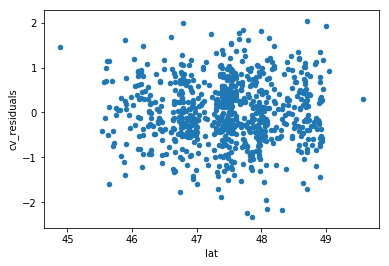

In [17]:
# lat
cv_feat_res_df.plot(x='lat',y='cv_residuals',kind='scatter')

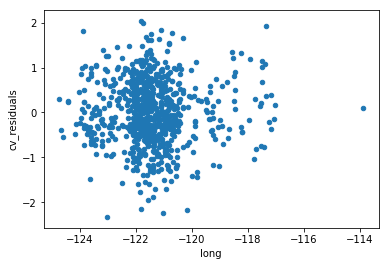

In [17]:
# longitude
cv_feat_res_df.plot(x='long',y='cv_residuals',kind='scatter')

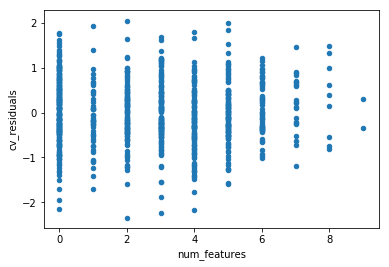

In [18]:
# num_features
cv_feat_res_df.plot(x='num_features',y='cv_residuals',kind='scatter')

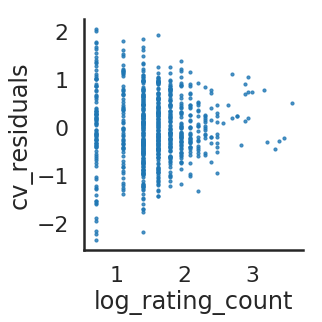

In [22]:
# rating_count
#cv_feat_res_df.plot(x='log_rating_count',y='cv_residuals',kind='scatter')
sns.lmplot(y='cv_residuals',x='log_rating_count',data=cv_feat_res_df,scatter_kws={"marker":"D","s": 10},fit_reg=False)
plt.savefig('residuals vs rating_count_log.png',dpi=300,transparent=True)

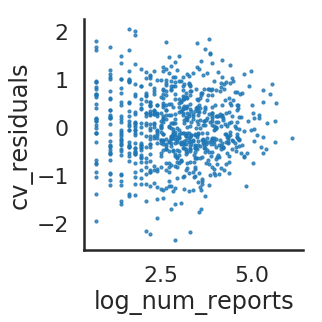

In [24]:
# num_reports
#cv_feat_res_df.plot(x='log_num_reports',y='cv_residuals',kind='scatter')
sns.lmplot(y='cv_residuals',x='log_num_reports',data=cv_feat_res_df,scatter_kws={"marker":"D","s": 10},fit_reg=False)
plt.savefig('residuals vs num_reports_log.png',dpi=300,transparent=True)

Text(0.5, 1.0, 'Normal Q-Q plot')

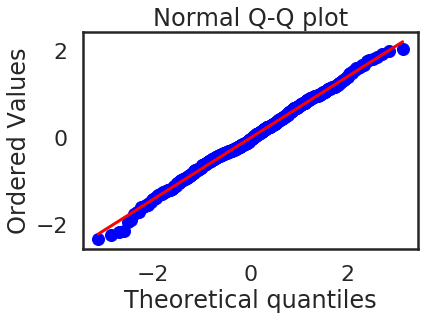

In [25]:
# Q-Q plot
stats.probplot(cv_feat_res_df.cv_residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [26]:
df.corr()['rating']

rating                   1.000000
Established campsites    0.036365
Mountain views           0.065164
Ridges/passes            0.047071
Summits                  0.147722
Waterfalls               0.109722
Wildflowers/Meadows      0.034122
distance_mi              0.018835
highest_pt               0.023482
lat                     -0.045615
long                    -0.036234
Issaquah Alps           -0.035553
Mount Rainier Area       0.015320
North Cascades          -0.063321
Snoqualmie Region       -0.010487
National Park Pass       0.074774
Northwest Forest Pass   -0.021606
Sno-Parks Permit        -0.059529
num_features             0.136155
log_num_reports          0.200614
log_rating_count         0.110985
Name: rating, dtype: float64

# Standard Scalar

In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lr_scalar = LinearRegression()
lr_scalar.fit(X_train_scaled, y_train)
predictions2 = lr.predict(X_val_scaled)

print('MAE:', metrics.mean_absolute_error(y_val, predictions2))
print('MSE:', metrics.mean_squared_error(y_val, predictions2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, predictions2)))
print('R^2:', metrics.explained_variance_score(y_val,predictions2))

MAE: 6.258008587376504
MSE: 40.77307235385437
RMSE: 6.385379577899372
R^2: -1.9804219739698086


**when I scale, looks like overfitting (negative R2)** 

or.... my effect is just super small... 

# Ridge Regression

In [19]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train_scaled, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Established campsites', 1.792845178100842e-11),
 ('Mountain views', 2.6680709246334342e-11),
 ('Ridges/passes', 7.832713341825205e-12),
 ('Summits', 4.65611683557605e-11),
 ('Waterfalls', 4.339702998441377e-11),
 ('Wildflowers/Meadows', 6.361612550784298e-12),
 ('distance_mi', -6.484330611083975e-12),
 ('highest_pt', -1.1548558931072187e-11),
 ('lat', -3.6692692928932553e-11),
 ('long', -1.8853785929786683e-11),
 ('Issaquah Alps', -2.4996879887137244e-11),
 ('Mount Rainier Area', 2.858288922152521e-12),
 ('North Cascades', -2.850942288787806e-11),
 ('Snoqualmie Region', 4.820956961165037e-12),
 ('National Park Pass', 2.8277568803313582e-11),
 ('Northwest Forest Pass', 1.1353572004150399e-11),
 ('Sno-Parks Permit', -3.66866258371305e-11),
 ('num_features', 4.564840953634871e-11),
 ('log_num_reports', 7.751786444943345e-11),
 ('log_rating_count', 4.736589635266959e-11)]

In [20]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [21]:
alphalist = 10**(np.linspace(-4,1,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]
    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    ridge_predict = pipe.predict(X_val.values)
    err_vec_val[i] = mae(y_val, ridge_predict)

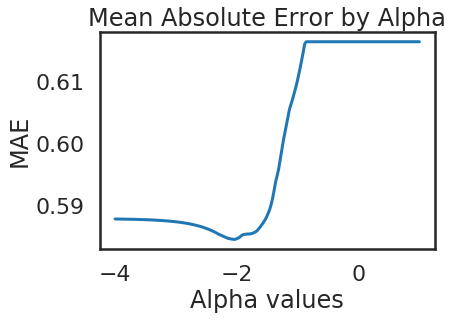

In [31]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)
plt.xlabel('Alpha values')
plt.ylabel('MAE')
plt.title('Mean Absolute Error by Alpha')
plt.savefig('ridge_regression.png',dpi=300,transparent=True)

### ideal alpha seems to be -2

In [22]:
# minimum error
min_error = np.min(err_vec_val)
min_error

0.5844899029133794

In [23]:
r2_score(y_val, ridge_predict)

-0.012733209083976238

### RidgeCV

In [24]:
rcv_alphas = 10**np.linspace(-4,1,200)

ridgeCV_model = RidgeCV(alphas = rcv_alphas, cv=5)
ridgeCV_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000e-04, 1.05956e-04, ..., 9.43788e+00, 1.00000e+01]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [25]:
best_alpha = ridgeCV_model.alpha_
best_alpha

10.0

In [26]:
list(zip(X_train.columns, ridgeCV_model.coef_))

[('Established campsites', 0.006954791776273107),
 ('Mountain views', 0.03608873047650876),
 ('Ridges/passes', 0.0011256930053716563),
 ('Summits', 0.08732667542518485),
 ('Waterfalls', 0.05516742201964577),
 ('Wildflowers/Meadows', -0.024737775962479277),
 ('distance_mi', -0.05240164835947549),
 ('highest_pt', -0.06850966974226409),
 ('lat', -0.05796813944013337),
 ('long', 0.03126828398111132),
 ('Issaquah Alps', -0.08086049159086445),
 ('Mount Rainier Area', -0.039530371989564536),
 ('North Cascades', -0.040148523400968854),
 ('Snoqualmie Region', -0.029856159372935287),
 ('National Park Pass', 0.0464207644904152),
 ('Northwest Forest Pass', 0.0013596161532526921),
 ('Sno-Parks Permit', -0.060347110861474436),
 ('num_features', 0.02996165091738557),
 ('log_num_reports', 0.143268962318726),
 ('log_rating_count', 0.0037495556380272676)]

In [27]:
ridgeCV_predict = ridgeCV_model.predict(X_val_scaled)

In [28]:
mae(y_val, ridgeCV_predict)

0.5877936892410798

In [29]:
r2_score(y_val, ridgeCV_predict)

0.0702680521426573

# Remove features!

In [82]:
df.columns

Index(['rating', 'Established campsites', 'Mountain views', 'Ridges/passes',
       'Summits', 'Waterfalls', 'Wildflowers/Meadows', 'distance_mi',
       'highest_pt', 'lat', 'long', 'Issaquah Alps', 'Mount Rainier Area',
       'North Cascades', 'Snoqualmie Region', 'National Park Pass',
       'Northwest Forest Pass', 'Sno-Parks Permit', 'num_features',
       'log_num_reports', 'log_rating_count'],
      dtype='object')

In [40]:
X3 = df[['num_features','log_num_reports', 'log_rating_count']]
y3 = df['rating']

# hold out 20% of the data for final testing
X3, X3_test, y3, y3_test = train_test_split(X3, y3, test_size=.2, random_state=10)

In [41]:
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=.25, random_state=3)
lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)
predictions3 = lr3.predict(X3_val)

print('MAE:', metrics.mean_absolute_error(y3_val, predictions3))
print('MSE:', metrics.mean_squared_error(y3_val, predictions3))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y3_val, predictions3)))
print('R^2:', metrics.explained_variance_score(y3_val,predictions3))

MAE: 0.5964059342852996
MSE: 0.5519495586316376
RMSE: 0.7429330781649433
R^2: 0.06391874893291238


In [96]:
df.corr()['rating']

rating                   1.000000
Established campsites    0.036365
Mountain views           0.065164
Ridges/passes            0.047071
Summits                  0.147722
Waterfalls               0.109722
Wildflowers/Meadows      0.034122
distance_mi              0.018835
highest_pt               0.023482
lat                     -0.045615
long                    -0.036234
Issaquah Alps           -0.035553
Mount Rainier Area       0.015320
North Cascades          -0.063321
Snoqualmie Region       -0.010487
National Park Pass       0.074774
Northwest Forest Pass   -0.021606
Sno-Parks Permit        -0.059529
num_features             0.136155
log_num_reports          0.200614
log_rating_count         0.110985
Name: rating, dtype: float64

#### Highest correlations: 
* summits
* waterfalls
* num features
* log num reports
* log rating count 

# Summits,  Waterfalls, Num Features, Log Num reports, Log rating count: 

MAE: 0.5879286211086868
MSE: 0.5426298916791191
RMSE: 0.7366341640727229
R^2: 0.08228896792953688

Summits:          0.01
Waterfalls:       0.01
log num reports:  0.07
log rating count: 0.01
num features:     0.01

In [42]:
X3 = df[['num_features']]
y3 = df['rating']

# hold out 20% of the data for final testing
X3, X3_test, y3, y3_test = train_test_split(X3, y3, test_size=.2, random_state=10)

X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=.25, random_state=3)
lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)
predictions3 = lr3.predict(X3_val)

print('MAE:', metrics.mean_absolute_error(y3_val, predictions3))
print('MSE:', metrics.mean_squared_error(y3_val, predictions3))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y3_val, predictions3)))
print('R^2:', metrics.explained_variance_score(y3_val,predictions3))

MAE: 0.6135800884590362
MSE: 0.5804624773989728
RMSE: 0.7618808813712107
R^2: 0.010831383462121091
